# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.102756,False,-0.009900
1,0.969396,False,-0.357507
2,-1.320448,False,-1.597761
3,0.867252,False,2.129515
4,-0.618217,False,-0.907962
...,...,...,...
995,0.540772,True,6.075869
996,0.669285,True,5.225582
997,-1.837495,False,-2.277313
998,-1.433466,False,-0.604839


<AxesSubplot: xlabel='v0'>

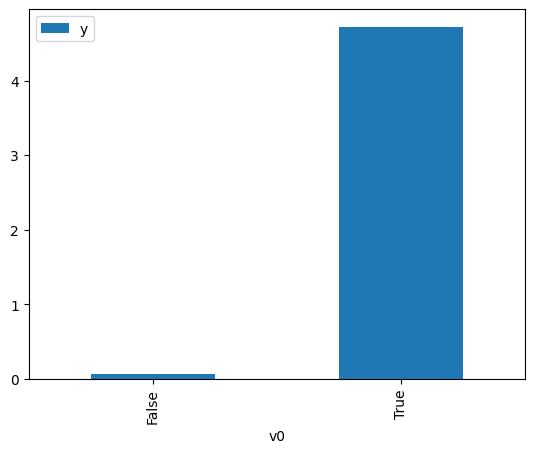

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

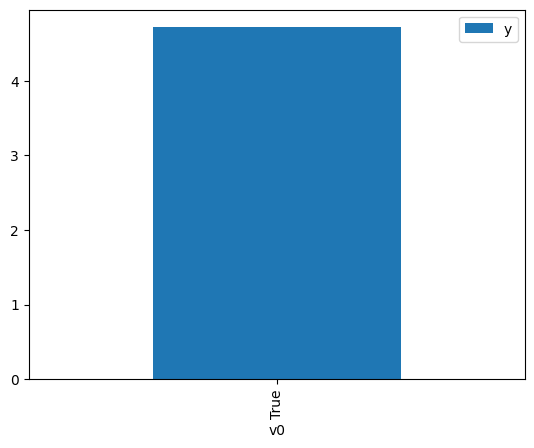

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.027603,False,-2.470187,0.539601,1.853222
1,-0.665134,False,-0.440792,0.771136,1.296788
2,0.666552,False,1.484390,0.270703,3.694082
3,-1.129130,False,-2.188294,0.879032,1.137615
4,1.429656,False,3.073468,0.094914,10.535826
...,...,...,...,...,...
995,0.212999,False,0.274853,0.440336,2.270991
996,1.353336,False,2.310446,0.106344,9.403429
997,0.746924,False,-0.421500,0.245236,4.077707
998,0.719841,False,0.548963,0.253634,3.942692


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.652974,True,8.405848,0.986364,1.013824
1,-1.431244,True,2.714301,0.077008,12.985693
2,-1.197635,True,4.322645,0.109412,9.139798
3,-1.651322,True,2.663955,0.054772,18.257509
4,1.546261,True,6.410227,0.920430,1.086449
...,...,...,...,...,...
995,-0.725673,True,4.786230,0.211649,4.724793
996,-2.410124,True,0.852103,0.016221,61.650102
997,1.287301,True,6.243488,0.882804,1.132754
998,-0.191803,True,6.500951,0.393956,2.538355


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              8409.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):                        0.00
Time:                        09:16:36   Log-Likelihood:                         -1438.6
No. Observations:                1000   AIC:                                      2881.
Df Residuals:                     998   BIC:                                      2891.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2487      0.036     34.235      0.000       1.177       1.320
x2             5.0163      0.051     98.863      0.000       4.917       5.116
==============================================================================
Omnibus:                        1.473   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.342
Skew:                           0.078   Prob(JB):                        0.511
Kurtosis:                       3.088   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""